In [1]:
# %pip install plotly
# %pip install nltk
# # %pip install tensorflow
# # %pip install seaborn
# # %pip install sklearn
# # %pip install pandas
# %pip install cufflinks
# # %pip install jupyterlab 
# %pip install ipywidgets
# %pip install pydot

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time
from datetime import date
# Not supported in python 3.7 or above
# from wordcloud import WordCloud, STOPWORDS
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
# Natural Language Tool Kit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
import cufflinks as cf
import pandas as pd
cf.go_offline()

C:\Users\Manish Raj Osti\AppData\Local\Temp\ipykernel_5956\4011471396.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[nltk_data] Downloading package stopwords to C:\Users\Manish Raj
[nltk_data]     Osti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:
data_df = pd.read_csv("data.csv")
print(f"Data shape {data_df.shape}")
data = data_df.iloc[:900000,:]
print(f"Data shape {data.shape}")

Data shape (1371202, 4)
Data shape (900000, 4)


In [159]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_url(text):
    no_html= pattern.sub('',text)
    return no_html

# Remove all text that start with http
data.text = data.text.apply(lambda x: remove_url(x))
data.head()

,id,location,text,target
0,1,Europe,Trump says Republicans would ‘never’ be electe...,0
1,2,NaN,@realDonaldTrump Listen to Bill Gates. You ig...,1
2,3,"Edmonton, Alberta",RT @gtconway3d:,1
3,4,UK,How coronavirus could permanently change our l...,1
4,5,NaN,"RT @phscoop: D.C., Virginia and Maryland coron...",1


In [160]:
# now remove stopwords, change to lowercase

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    # split to array (default delimiter is " ")
    text = text.split()
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

print("Cleaning text...")
data.text = data.text.apply(lambda x : clean_text(x))
data.head()

Cleaning text...


,id,location,text,target
0,1,Europe,trump says republicans would never elected eas...,0
1,2,NaN,realdonaldtrump listen bill gates ignored mont...,1
2,3,"Edmonton, Alberta",rt gtconway,1
3,4,UK,coronavirus could permanently change lives acc...,1
4,5,NaN,rt phscoop c virginia maryland coronavirus upd...,1


In [161]:
# How many unique words int this dataset

def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text_values = data.text
counter = counter_word(text_values)
print(f"The len of words is: {len(counter)}")
list(counter.items())[:10]

The len of words is: 224598


[('trump', 100100),
 ('says', 35955),
 ('republicans', 3897),
 ('would', 12673),
 ('never', 5111),
 ('elected', 529),
 ('easier', 394),
 ('vote', 2394),
 ('realdonaldtrump', 20576),
 ('listen', 1742)]

In [162]:
train, test, train_category, test_category = train_test_split(data.text, data.target, test_size=0.15, random_state=42)
train_category.value_counts()

1    458043
0    306957
Name: target, dtype: int64

In [163]:
test_category.value_counts()

1    80615
0    54385
Name: target, dtype: int64

In [164]:
train_category.value_counts().iplot(kind='bar',
                                     text=['Trustworthy', 'non-Trustworthy'],
                                     title='Class Distribution of Train/Validation Dataset',
                                     color=['green'])

In [165]:
test_category.value_counts().iplot(kind='bar',
                                     text=['Trustworthy', 'non-Trustworthy'],
                                     title='Class Distribution of Test Dataset',
                                     color=['green'])

In [166]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint
max_length = 20
trunc_type = 'post'
padding_type = 'pre'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = int(len(train) * 0.8)
seq_len = 12

# based on 80% of the data
training_sentences = train[0:training_size]
training_labels = train_category[0:training_size]

valid_sentences = train[training_size:]
valid_labels = train_category[training_size:]

print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',valid_sentences.shape)

The Shape of training  (612000,)
The Shape of testing (153000,)


In [167]:
training_labels.value_counts()

1    366529
0    245471
Name: target, dtype: int64

In [168]:
valid_labels.value_counts()

1    91514
0    61486
Name: target, dtype: int64

In [169]:
training_labels.value_counts().iplot(kind='bar',
                                     text=['Trustworthy', 'non-Trustworthy'],
                                     title='Class Distribution of Train Dataset',
                                     color=['green'])

In [170]:
valid_labels.value_counts().iplot(kind='bar',
                                     text=['Trustworthy', 'non-Trustworthy'],
                                     title='Class Distribution of Validation Dataset',
                                     color=['green'])

In [171]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [172]:
# Lets see the first 10 elements
print("THe first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))

THe first word Index are: 
 <XXX>,  1 
 rt,  2 
 coronavirus,  3 
 covid,  4 
 trump,  5 
 guardian,  6 
 pandemic,  7 
 us,  8 
 new,  9 
 cases,  10 
 u,  11 
 people,  12 
 news,  13 
 china,  14 
 uk,  15 


In [173]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
T = training_padded.shape[0]
print("The shape of training data is: ",training_padded.shape, T)

The shape of training data is:  (612000, 20) 612000


In [174]:
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print("The shape of validation data is: ",valid_padded.shape)

The shape of validation data is:  (153000, 20)


In [179]:
#Model Definition with LSTM

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid') # binary classification
# ])


i = tf.keras.layers.Input(shape=(max_length,))
x= tf.keras.layers.Embedding(vocab_size+1, embedding_dim)(i)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
# x = tf.keras.layers.Dropout(0.2)(x)    #optional might be better to use dropout
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)



# i = tf.keras.layers.Input(shape=(max_length,))
# x = tf.keras.layers.Embedding(vocab_size+1, embedding_dim)(i)
# x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
# x = tf.keras.layers.MaxPooling1D(3)(x)
# x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
# # x = tf.keras.layers.MaxPooling1D(3)(x)
# x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
# x = tf.keras.layers.GlobalMaxPooling1D()(x)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.models.Model(inputs=i, outputs=x)

model.compile(tf.keras.optimizers.Nadam(learning_rate=0.001), loss= 'binary_crossentropy' , metrics=['accuracy'])
model.summary() 

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 20)]              0         
                                                                 
 embedding_43 (Embedding)    (None, 20, 32)            7187168   
                                                                 
 bidirectional_36 (Bidirecti  (None, 20, 128)          49664     
 onal)                                                           
                                                                 
 global_max_pooling1d_18 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_56 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,236,961
Trainable params: 7,236,961
Non-tr

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [180]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(valid_padded, valid_labels))


Epoch 1/30
13879/19125 [====================>.........] - ETA: 1:18 - loss: 0.2152 - accuracy: 0.9073

In [177]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.203773,0.912626,0.169647,0.928359
1,0.139645,0.942606,0.161738,0.932327
2,0.111377,0.955788,0.161564,0.930379
3,0.090599,0.964196,0.180797,0.924131
4,0.075604,0.969998,0.190962,0.924484


<AxesSubplot:>

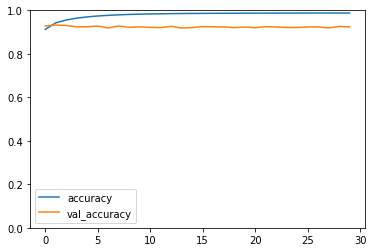

In [178]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1])

In [34]:
predictions = (model.predict(valid_padded) > 0.5).astype("int32")
predictions

array([[1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1]])

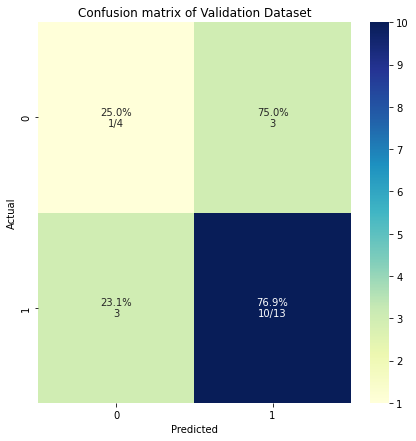

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
# Showing Confusion Matrix
plot_cm(valid_labels,predictions, 'Confusion matrix of Validation Dataset', figsize=(7,7))

In [36]:
testing_sequences = tokenizer.texts_to_sequences(test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = (model.predict(testing_padded) > 0.5).astype("int32")

predictions

array([[0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]])

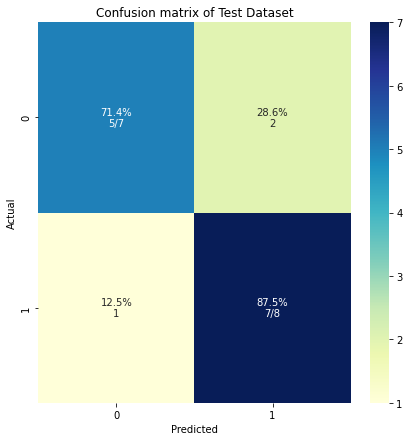

In [37]:
# Showing Confusion Matrix
plot_cm(test_category,predictions, 'Confusion matrix of Test Dataset', figsize=(7,7))

In [35]:
model.save(f"models/Bi-LSTM ({date.today().strftime('%m-%d-%y')})")

2022-01-07 18:47:55.292745: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Bi-LSTM (01-07-2022)/assets


INFO:tensorflow:Assets written to: Bi-LSTM (01-07-2022)/assets
